# N2 trend over Basin

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import scipy.io as sio
import os
import matplotlib.pyplot as plt

import topo as topo

In [2]:
def err_from_mean(var, var_err, var_eDOF, confidence_level=0.95):
    """assume all variables are independent, 
    can use error propagation to compute the error of the mean,
    given error of each variables
    
    eDOF = sum(eDOF)
    
    var: (LL_st, z_N2) or (z_N2)
    """
    
    import scipy.stats
    
    if len(var.shape) == 2:
        var_mean_ = np.zeros(len(var[0,:]),) + np.nan
        var_err_ = np.zeros(len(var[0,:]),) + np.nan
        var_CI_ = np.zeros((len(var[0,:]),2)) + np.nan
        for i in range(len(var[0,:])):
            idx_good = (~np.isnan(var_err[:,i])) & (~np.isinf(var_err[:,i]))
            if len(var_err[idx_good,i])>0:
                var_mean_[i] = np.mean(var[idx_good,i])
                var_err_[i] = np.sqrt(np.sum(var_err[idx_good,i]**2))/len(var_err[idx_good,i])
                var_CI_[i,:] = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good,i]), var_mean_[i], var_err_[i]) 
    else:
        idx_good = (~np.isnan(var_err)) & (~np.isinf(var_err))
        if len(var_err[idx_good])>0:
            var_mean_ = np.mean(var[idx_good])
            var_err_ = np.sqrt(np.sum(var_err[idx_good]**2))/len(var_err[idx_good])
            var_CI_ = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good]), var_mean_, var_err_) 
        else:
            var_mean_ = np.nan
            var_err_ = np.nan
            var_CI_ = np.array([np.nan, np.nan])
                
    return var_mean_, var_err_, var_CI_

In [3]:
def Basin_data(datafilepath, section_name, section_loc, method, data_name, var_name):
    """method = 1: lon section
       method = 0, lat section """
    from scipy.interpolate import interp1d
    
    count = 0
    for i in range(len(section_name)):
        acquisition = section_name[i]
        try:
            count += 1
            Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_" + data_name + ".nc")
            if count == 1:
                var = eval("Data_trend."+var_name+"_mean.data")
                var_err = eval("Data_trend."+var_name+"_err.data")
                var_eDOF = eval("Data_trend.eDOF.data")
                if method[i]:
                    var_lat = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = f(var_lat)
                else:
                    var_lon = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = f(var_lon)

            else:
                var = np.vstack((eval("Data_trend."+var_name+"_mean.data"), var))
                var_err = np.vstack((eval("Data_trend."+var_name+"_err.data"), var_err))
                var_eDOF = np.vstack((eval("Data_trend.eDOF.data"), var_eDOF))
                if method[i]:
                    var_lat = np.hstack((Data_trend.LL_st.data, var_lat))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = np.hstack((f(Data_trend.LL_st.data), var_lon))
                else:
                    var_lon = np.hstack((Data_trend.LL_st.data, var_lon))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = np.hstack((f(Data_trend.LL_st.data), var_lat))
        except FileNotFoundError:
            pass
    
    var_lon[var_lon<0]+=360
            
    return var, var_err, var_eDOF, var_lat, var_lon

# def Basin_data(datafilepath, section_name, section_loc, method, data_name, var_name):
#     """method = 1: lon section
#        method = 0, lat section """
#     count = 0
#     for i in range(len(section_name)):
#         acquisition = section_name[i]
#         try:
#             count += 1
#             Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_" + data_name + ".nc")
#             if count == 1:
#                 var = eval("Data_trend."+var_name+"_mean.data")
#                 var_err = eval("Data_trend."+var_name+"_err.data")
#                 var_eDOF = eval("Data_trend.eDOF.data")
#                 if method[i]:
#                     var_lat = Data_trend.LL_st.data
#                     var_lon = np.zeros((len(Data_trend.LL_st.data),)) + section_loc[i]
#                 else:
#                     var_lat = np.zeros((len(Data_trend.LL_st.data),)) + section_loc[i]
#                     var_lon = Data_trend.LL_st.data
#             else:
#                 var = np.vstack((eval("Data_trend."+var_name+"_mean.data"), var))
#                 var_err = np.vstack((eval("Data_trend."+var_name+"_err.data"), var_err))
#                 var_eDOF = np.vstack((eval("Data_trend.eDOF.data"), var_eDOF))
#                 if method[i]:
#                     var_lat = np.hstack((Data_trend.LL_st.data, var_lat))
#                     var_lon = np.hstack((np.zeros((len(Data_trend.LL_st.data),)) + section_loc[i], var_lon))
#                 else:
#                     var_lat = np.hstack((np.zeros((len(Data_trend.LL_st.data),)) + section_loc[i], var_lat))
#                     var_lon = np.hstack((Data_trend.LL_st.data, var_lon))
#         except FileNotFoundError:
#             pass
    
#     var_lon[var_lon<0]+=360
            
#     return var, var_err, var_eDOF, var_lat, var_lon


In [4]:
def within_basin(var_lon, var_lat, k):
    """input an arry of lon and lat, output mask for the kth basin in the basin boundary data from Purkey and Johnson (2010)
    https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
    """
    
    basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

    keys = {0: ['GB', 'Guatemala basin'],
    1: ['', ''],
    2: ['PER', 'Peru basin'],
    3: ['CHI', 'Chile basin'], 
    4: ['SWP', 'Southwest Pacific basin'], 
    5: ['', ''],
    6: ['ABB', 'Amundsen‐Bellingshausen basin'],
    7: ['CS', 'Coral Sea'], 
    8: ['PB', 'Pacific basin'], 
    9: ['TAS', 'Tasman Sea'],
    10: ['SB', 'Somali basin'],
    11: ['SAB', 'South Australian basin'], 
    12: ['OS', 'Okhotsk Sea'],
    13: ['BS', 'Bering Sea'],
    14: ['ARG', 'Argentine basin'],
    15: ['BB', 'Brazil basin'],
    16: ['', ''],
    17: ['NAB', 'North Atlantic basin'],
    18: ['AGU', 'Agulhas–Mozambique basin'],
    19: ['ANG', 'Angola basin'],
    20: ['IB', 'Iberian/Canary/Cape Verde basin'], 
    21: ['AS', 'Arabian Sea'],
    22: ['WEB', 'Weddell–Enderby basin'],
    23: ['CAP', 'Cape basin'], 
    24: ['', ''],
    25: ['SS', 'Scotia Sea'], 
    26: ['MB', 'Madagascar basin'], 
    27: ['MIB', 'mid-Indian basin'], 
    28: ['WB', 'Wharton basin'], 
    29: ['CRO', 'Crozet basin'], 
    30: ['AAB', 'Australian-Antarctic basin'], 
    31: ['PHI', 'Philippine basin'], 
    32: ['ECS', 'east of Coral Sea'], }
    
    var_lon_ = var_lon.copy()
    var_lat_ = var_lat.copy()
    
    from matplotlib.path import Path
    for i in range(len(basin['bsn_only'][k].bsn[0])):
        if i == 0:
            basin_verts = [(basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i])]
        else:
            basin_verts.append((basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i]))
    basin_path = Path(basin_verts)
    if k == 19 | k == 23:
        var_lon_[var_lon_<basin['bsn_only'][k].bsn[0].max() - 360]+=360
    if k == 22:
        var_lon_[var_lon_>basin['bsn_only'][k].bsn[0].min() + 360]-=360
        
    var_mask = basin_path.contains_points(np.vstack((var_lon_,var_lat_)).T)
    
    return var_mask, keys

In [5]:
def plot_trend_over_basin(N2_trend, Topo, basin, ax, param_fig):
    
    import matplotlib
    cm0 = matplotlib.cm.PiYG_r
    norm0 = matplotlib.colors.SymLogNorm(linthresh=5e-8, 
                                         vmin=-1e-7, vmax=1e-7, base=10)
    sm0 = matplotlib.cm.ScalarMappable(cmap=cm0, norm=norm0)
    sm0.set_array([])

    color_name = 'k'
    # Topo[::10,::10].plot.contour(ax=ax, levels=[0], x='longitude', y='latitude', colors='.5', linewidths=.5)
    Topo[::10,::10].T.plot.contourf(ax=ax, levels=[0, 10], cmap=ListedColormap(['1', '.7']), add_colorbar=0)
    for i in range(len(basin['bsn_only'])):
        lon = basin['bsn_only'][i].bsn[0].copy()
        lat = basin['bsn_only'][i].bsn[1].copy()
        lon_ = lon.copy()
        lat_ = lat.copy()
        lon__ = lon.copy()
        lat__ = lat.copy()    
        lat[(lon<0) | (lon>360)] = np.nan
        lon[(lon<0) | (lon>360)] = np.nan
        ax.plot(lon,  lat, c='k')
        lat_[lon_>=0] = np.nan
        lon_[lon_>=0] = np.nan
        lon_[lon_<0] += 360
        ax.plot(lon_, lat_, c='k')
        lat__[lon__<=360] = np.nan
        lon__[lon__<=360] = np.nan
        lon__[lon__>=360] -= 360
        ax.plot(lon__, lat__, c='k')

    count = 0
    for i in N2_trend.basin_idx.data:
        lon = basin['bsn_only'][i].bsn[0].copy()
        lat = basin['bsn_only'][i].bsn[1].copy()
        lon_ = lon.copy()
        lat_ = lat.copy()
        lon__ = lon.copy()
        lat__ = lat.copy()   

        lon[lon>360] = 360
        lon[lon<0] = 0
    #     ax.plot(lon,  lat, c='g')
        lon_[lon_>=0] = np.nan
        lon_[lon_<0] += 360
    #     ax.plot(lon_, lat_, c='g')
        lon__[lon__<=360] = np.nan
        lon__[lon__>=360] -= 360
    #     ax.plot(lon__, lat__, c='g')

        color_ = sm0.to_rgba(N2_trend.N2_trend[count,param_fig['z_at']].data)

        if N2_trend.N2_trend[count,param_fig['z_at']].data>0:
            if N2_trend.N2_trend_CI_95[count,param_fig['z_at'],0].data>0:
                ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_)    
                ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_)    
                ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_)    
            elif N2_trend.N2_trend_CI_85[count,param_fig['z_at'],0].data>0:
                    ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_,hatch='-')    
                    ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_,hatch='-')      
                    ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_,hatch='-')  
            elif N2_trend.N2_trend_CI_68[count,param_fig['z_at'],0].data>0:
                    ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_,hatch='x')    
                    ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_,hatch='x')      
                    ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_,hatch='x')     
        if N2_trend.N2_trend[count,param_fig['z_at']].data<0:
            if N2_trend.N2_trend_CI_95[count,param_fig['z_at'],1].data<0:
                ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_)    
                ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_)    
                ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_)  
            elif N2_trend.N2_trend_CI_85[count,param_fig['z_at'],1].data<0:
                    ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_,hatch='-')     
                    ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_,hatch='-')      
                    ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_,hatch='-')  
            elif N2_trend.N2_trend_CI_68[count,param_fig['z_at'],1].data<0:
                    ax.fill(lon[~np.isnan(lon)],lat[~np.isnan(lon)],facecolor=color_,hatch='x')     
                    ax.fill(lon_[~np.isnan(lon_)],lat_[~np.isnan(lon_)],facecolor=color_,hatch='x')      
                    ax.fill(lon__[~np.isnan(lon__)],lat__[~np.isnan(lon__)],facecolor=color_,hatch='x') 
        count+=1

    # plt.colorbar(sm0)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=20)
    # ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xticks(np.arange(0, 360+1, 30))
    ax.set_xticklabels(['0$^{\circ}$','30$^{\circ}$E','60$^{\circ}$E','90$^{\circ}$E',
                        '120$^{\circ}$E','150$^{\circ}$E','180$^{\circ}$','150$^{\circ}$W','120$^{\circ}$W',
                        '90$^{\circ}$W','60$^{\circ}$W','30$^{\circ}$W','0$^{\circ}$'])
    ax.set_yticks(np.arange(-90, 90+1, 30))
    ax.set_yticklabels(['90$^{\circ}S$','60$^{\circ}$S','30$^{\circ}$S','0$^{\circ}$',
                        '30$^{\circ}$N','60$^{\circ}$N','90$^{\circ}$N'])

    if param_fig['cbar_on']:
        cbar = fig.colorbar(sm0, extend='both')
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(label='d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=15)
        
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])
    plt.tight_layout()


In [6]:
def plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax):
    import matplotlib
    cm0 = matplotlib.cm.PiYG_r
    norm0 = matplotlib.colors.SymLogNorm(linthresh=5e-8, 
                                         vmin=-1e-7, vmax=1e-7, base=10)
    sm0 = matplotlib.cm.ScalarMappable(cmap=cm0, norm=norm0)
    sm0.set_array([])

    color_name = 'k'
    # Topo[::10,::10].plot.contour(ax=ax, levels=[0], x='longitude', y='latitude', colors='.5', linewidths=.5)
    Topo[::10,::10].T.plot.contourf(ax=ax, levels=[0, 10], cmap=ListedColormap(['1', '.7']), add_colorbar=0)
    for i in range(len(basin['bsn_only'])):
        lon = basin['bsn_only'][i].bsn[0].copy()
        lat = basin['bsn_only'][i].bsn[1].copy()
        lon_ = lon.copy()
        lat_ = lat.copy()
        lon__ = lon.copy()
        lat__ = lat.copy()    
        lat[(lon<0) | (lon>360)] = np.nan
        lon[(lon<0) | (lon>360)] = np.nan
        ax.plot(lon,  lat, c='k')
        lat_[lon_>=0] = np.nan
        lon_[lon_>=0] = np.nan
        lon_[lon_<0] += 360
        ax.plot(lon_, lat_, c='k')
        lat__[lon__<=360] = np.nan
        lon__[lon__<=360] = np.nan
        lon__[lon__>=360] -= 360
        ax.plot(lon__, lat__, c='k')
        
    for i in range(len(var_lon)):
        if ~np.isnan(var_trend[i]):
            ax.plot(var_lon[i], var_lat[i], 'k.')
        if var_trend_CI[i,1]<0 or var_trend_CI[i,0]>0:
            ax.plot(var_lon[i], var_lat[i], color=sm0.to_rgba(var_trend[i]), marker='o', markersize=10)
                
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=20)
    # ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xticks(np.arange(0, 360+1, 30))
    ax.set_xticklabels(['0$^{\circ}$','30$^{\circ}$E','60$^{\circ}$E','90$^{\circ}$E',
                        '120$^{\circ}$E','150$^{\circ}$E','180$^{\circ}$','150$^{\circ}$W','120$^{\circ}$W',
                        '90$^{\circ}$W','60$^{\circ}$W','30$^{\circ}$W','0$^{\circ}$'])
    ax.set_yticks(np.arange(-90, 90+1, 30))
    ax.set_yticklabels(['90$^{\circ}S$','60$^{\circ}$S','30$^{\circ}$S','0$^{\circ}$',
                        '30$^{\circ}$N','60$^{\circ}$N','90$^{\circ}$N'])

    if param_fig['cbar_on']:
        cbar = fig.colorbar(sm0, extend='both')
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(label='d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=15)

    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])
    plt.tight_layout()


## Parameters

In [7]:
# load bathymetry and create a DataArray object
Topo = topo.read_topo('../data/', 'ETOPO1_Bed_g_geotiff.tif', 1)
# read basin info
basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

In [8]:
# path to WOCE download data
resultfilepath = '../results/'
        
# path to saved data
outfilepath = '../figure/'

datafilepath = '/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/'

# location info
import pickle
loc_info = open(resultfilepath + 'EasyOcean_location.obj', 'rb')
loc = pickle.load(loc_info)
loc_info.close()

# default way to compute confidence interval of factors
method_mean = 3

## sig4-coordinate

In [9]:
section_name = loc["lon_sec"] + loc["lat_sec"]
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')
var, var_err, var_eDOF, var_lat, var_lon = Basin_data(
    datafilepath,
    section_name, 
    section_loc, 
    method, 
    "sig4_trend", 
    "trend_N2")
z_thred = [45.7, 45.95]

count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_sig4_block.nc")
        if count == 1:
            N2_z_ = Data_block.N2_mean[0,:,:].data
        else:
            N2_z_ = np.vstack((Data_block.N2_mean[0,:,:].data, N2_z_))

    except FileNotFoundError:
        pass


count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_sig4_block.nc")
        if count == 1:
            N2_z__ = Data_block.N2_mean.mean(axis=0, skipna=True).data
        else:
            N2_z__ = np.vstack((Data_block.N2_mean.mean(axis=0, skipna=True).data, N2_z__))

    except FileNotFoundError:
        pass

z_N2 = np.round(Data_block.z_N2.data, 3)
N2_z_.shape, N2_z__.shape, var.shape

((588, 33), (588, 33), (588, 33))

In [10]:
N2_trend_all = xr.open_dataset(resultfilepath + 'N2_trend_basin_sig4_all.nc')

In [11]:
param_fig = {'z_at': 1,
             'method_at': -1,
             'pic_name': 'densitylayer_low', 
             'cbar_on': 1,
}

In [12]:
var_lon.shape, var_lat.shape

((588,), (588,))

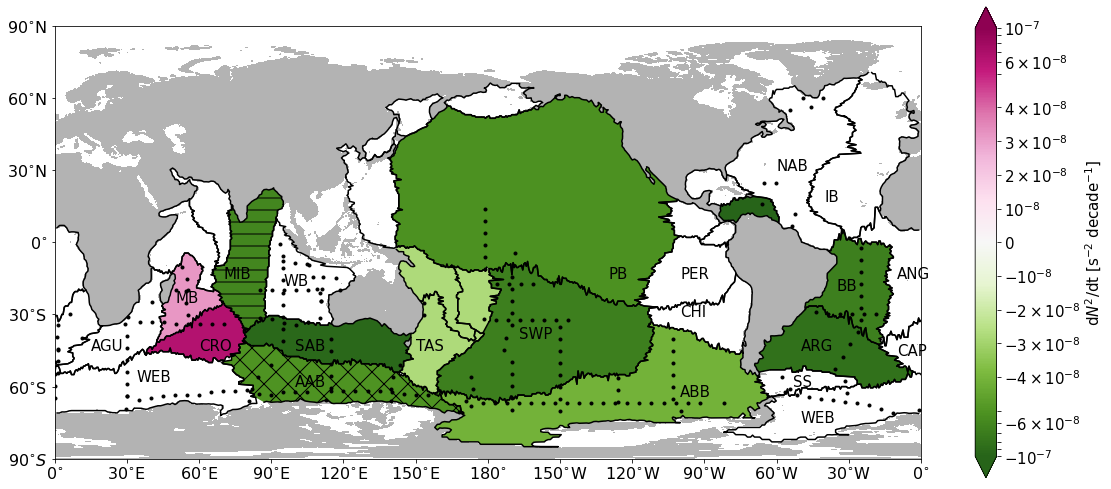

In [13]:
from matplotlib import cm

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['.7', 'y', 'dodgerblue', 'r'])
cmap.set_under('.7', 1.)
cmap.set_over('r', 1.)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_over_basin(N2_trend_all, Topo, basin, ax, param_fig)

_, var_keys = within_basin(var_lon, var_lat, 0)
for ii in range(len(var_keys)):
    idx_basin, var_keys = within_basin(var_lon, var_lat, ii)
    k = param_fig['z_at']
    lat_ = var_lat[idx_basin].copy()
    lon_ = var_lon[idx_basin].copy()
    for i in range(len(lat_)):
        if len(var[idx_basin, :][i, z_N2>=z_thred[k]][~np.isnan(var[idx_basin, :][i, z_N2>=z_thred[k]])]) == 0:
            lat_[i] = np.nan
            lon_[i] = np.nan
    ax.plot(lon_, lat_, '.', color='k')
    

ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.eps')


In [14]:
N2_trend_all.basin_names[-5].data, N2_trend_all.N2_trend[-5,-1].data, N2_trend_all.N2_trend_CI_68[-5,-1,:].data

(array('WB', dtype='<U2'),
 array(-4.54143029e-09),
 array([-1.02277059e-08,  1.14484527e-09]))

/Users/stan/miniforge3/envs/goship/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/stan/miniforge3/envs/goship/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


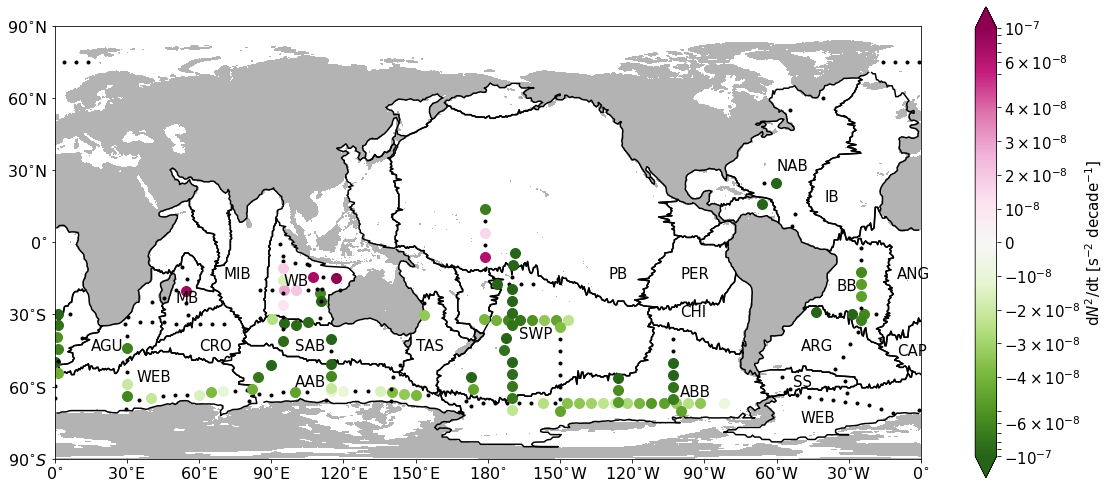

In [15]:
confidence_level=.95
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.eps')


/Users/stan/miniforge3/envs/goship/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/stan/miniforge3/envs/goship/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


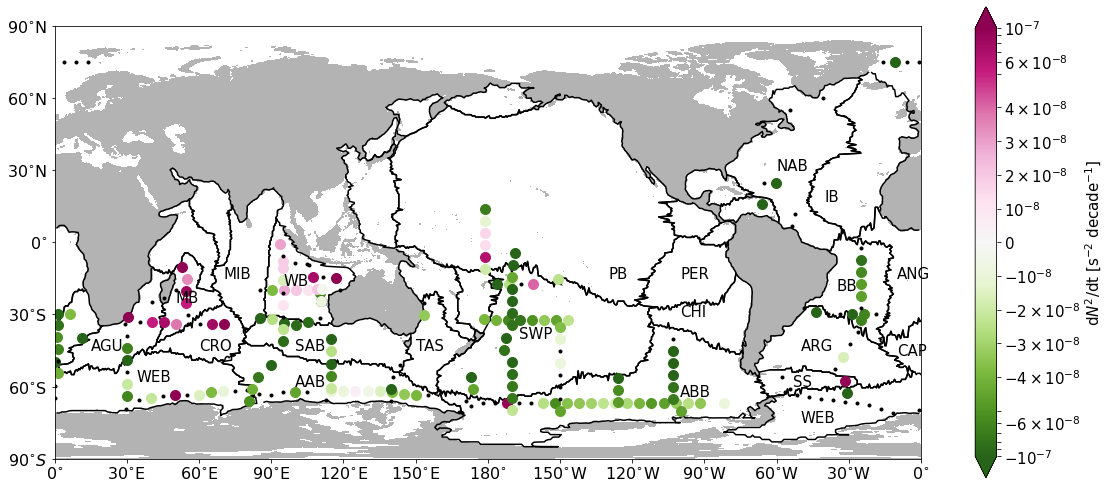

In [16]:
confidence_level=.68
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.eps')


In [17]:
param_fig = {'z_at': 0,
             'method_at': -1,
             'pic_name': 'densitylayer_up', 
             'cbar_on': 1,
}

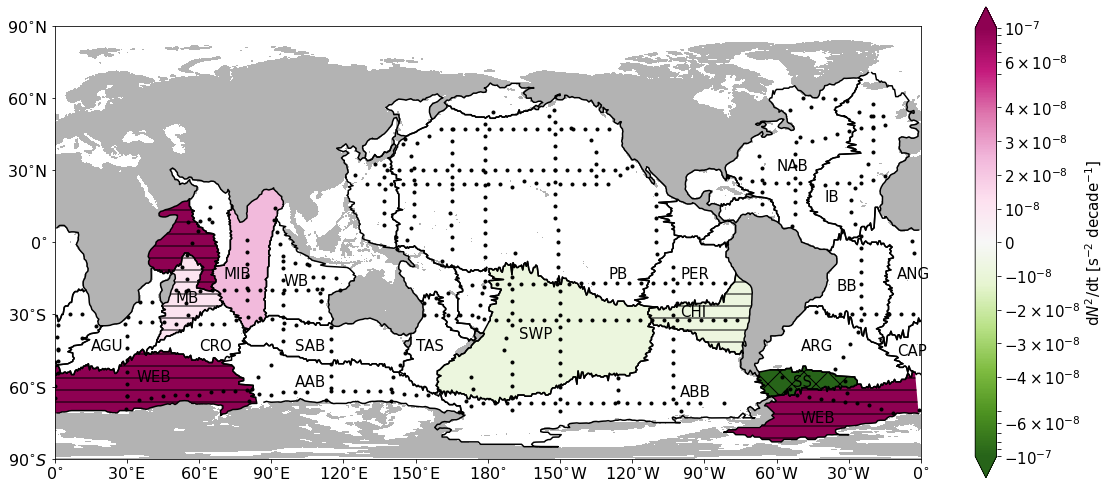

In [18]:
from matplotlib import cm

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['.7', 'y', 'dodgerblue', 'r'])
cmap.set_under('.7', 1.)
cmap.set_over('r', 1.)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_over_basin(N2_trend_all, Topo, basin, ax, param_fig)

_, var_keys = within_basin(var_lon, var_lat, 0)
for ii in range(len(var_keys)):
    idx_basin, var_keys = within_basin(var_lon, var_lat, ii)
    k = param_fig['z_at']
    lat_ = var_lat[idx_basin].copy()
    lon_ = var_lon[idx_basin].copy()
    for i in range(len(lat_)):
        if len(var[idx_basin, :][i, z_N2>=z_thred[k]][~np.isnan(var[idx_basin, :][i, z_N2>=z_thred[k]])]) == 0:
            lat_[i] = np.nan
            lon_[i] = np.nan
    ax.plot(lon_, lat_, '.', color='k')
    

ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.eps')


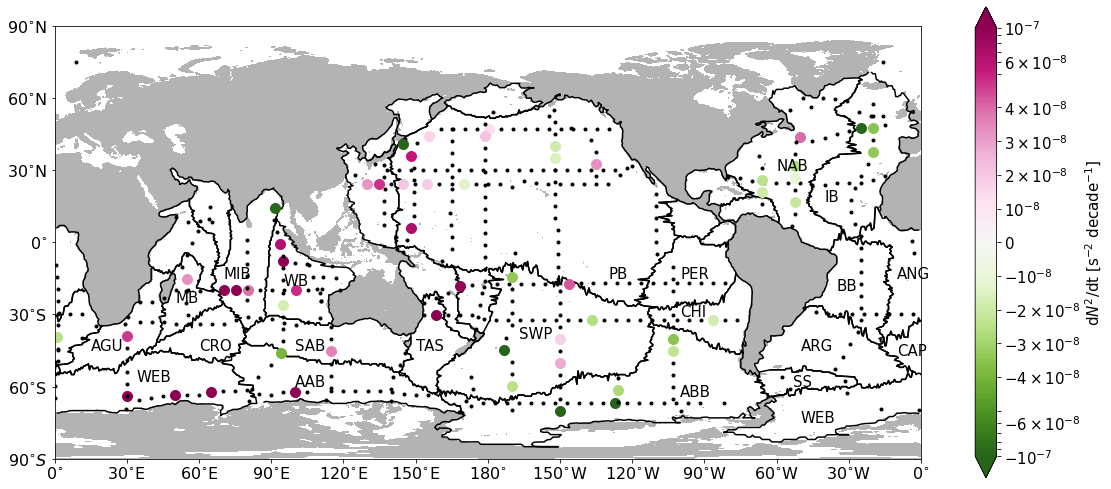

In [19]:
confidence_level=.95
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.eps')


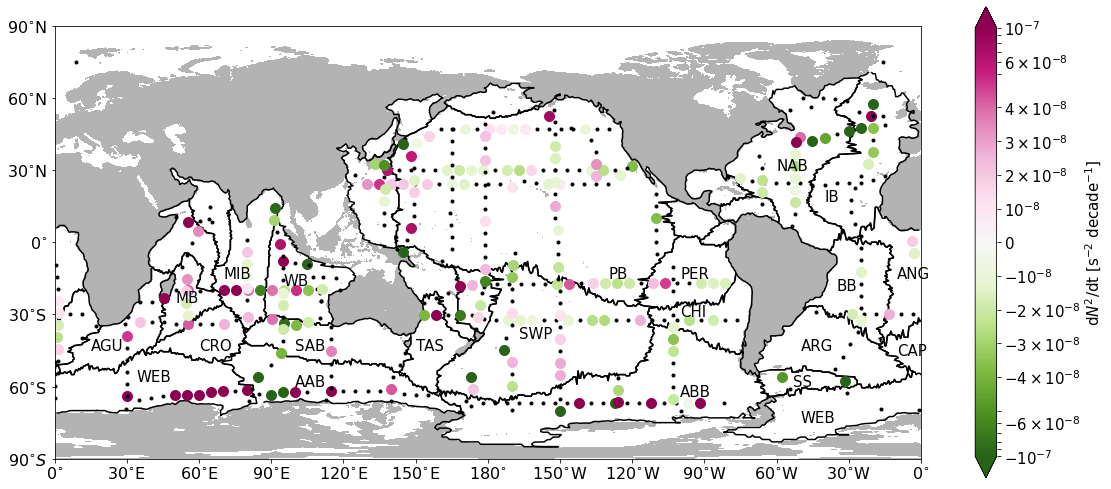

In [20]:
confidence_level=.68
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.eps')


## z-coordinate

In [21]:
section_name = loc["lon_sec"] + loc["lat_sec"]
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')
var, var_err, var_eDOF, var_lat, var_lon = Basin_data(
    datafilepath,
    section_name, 
    section_loc, 
    method, 
    "trend", 
    "trend_N2")
z_thred = [2000, 4000]

# ALL N2 change in one dataset, z-coordinate
count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_block.nc")
        if count == 1:
            N2_z_ = Data_block.N2_mean[0,:,:].data
        else:
            N2_z_ = np.vstack((Data_block.N2_mean[0,:,:].data, N2_z_))

    except FileNotFoundError:
        pass


count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_block.nc")
        if count == 1:
            N2_z__ = Data_block.N2_mean.mean(axis=0, skipna=True).data
        else:
            N2_z__ = np.vstack((Data_block.N2_mean.mean(axis=0, skipna=True).data, N2_z__))

    except FileNotFoundError:
        pass

z_N2 = Data_block.z_N2.data    
N2_z_.shape, N2_z__.shape, var.shape

((588, 17), (588, 17), (588, 17))

In [22]:
N2_trend_all = xr.open_dataset(resultfilepath + 'N2_trend_basin_z_all.nc')

In [23]:
param_fig = {'z_at': 1,
             'method_at': -1,
             'pic_name': 'depthlayer_low', 
             'cbar_on': 1,
}

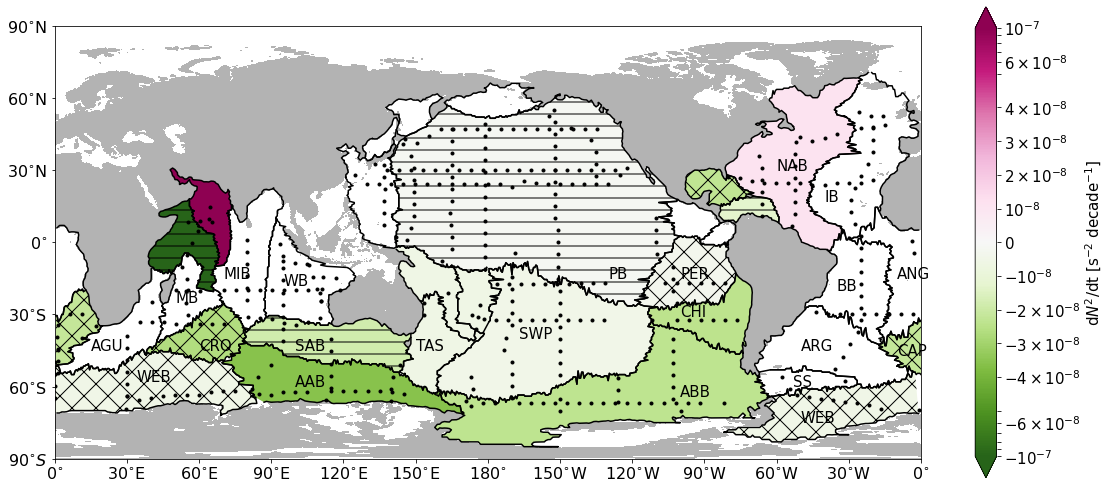

In [24]:
from matplotlib import cm

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['.7', 'y', 'dodgerblue', 'r'])
cmap.set_under('.7', 1.)
cmap.set_over('r', 1.)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_over_basin(N2_trend_all, Topo, basin, ax, param_fig)

_, var_keys = within_basin(var_lon, var_lat, 0)
for ii in range(len(var_keys)):
    idx_basin, var_keys = within_basin(var_lon, var_lat, ii)
    k = param_fig['z_at']
    lat_ = var_lat[idx_basin].copy()
    lon_ = var_lon[idx_basin].copy()
    for i in range(len(lat_)):
        if len(var[idx_basin, :][i, z_N2>=z_thred[k]][~np.isnan(var[idx_basin, :][i, z_N2>=z_thred[k]])]) == 0:
            lat_[i] = np.nan
            lon_[i] = np.nan
    ax.plot(lon_, lat_, '.', color='k')
    

ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.eps')


In [25]:
N2_trend_all.basin_names[-5].data, N2_trend_all.N2_trend[-5,-1].data, N2_trend_all.N2_trend_CI_68[-5,-1,:].data

(array('WB', dtype='<U2'),
 array(-1.47927537e-09),
 array([-1.01625011e-08,  7.20395038e-09]))

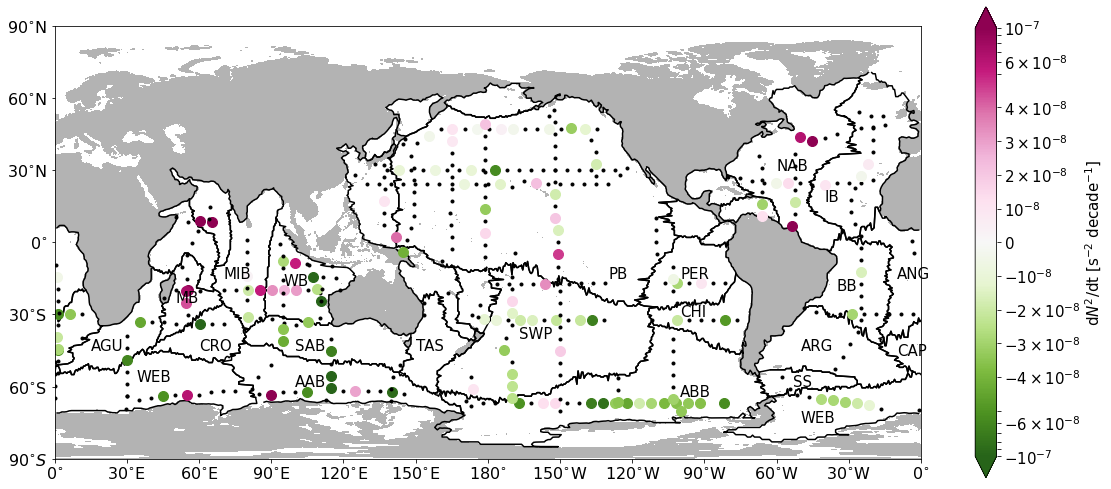

In [26]:
confidence_level=.95
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.eps')


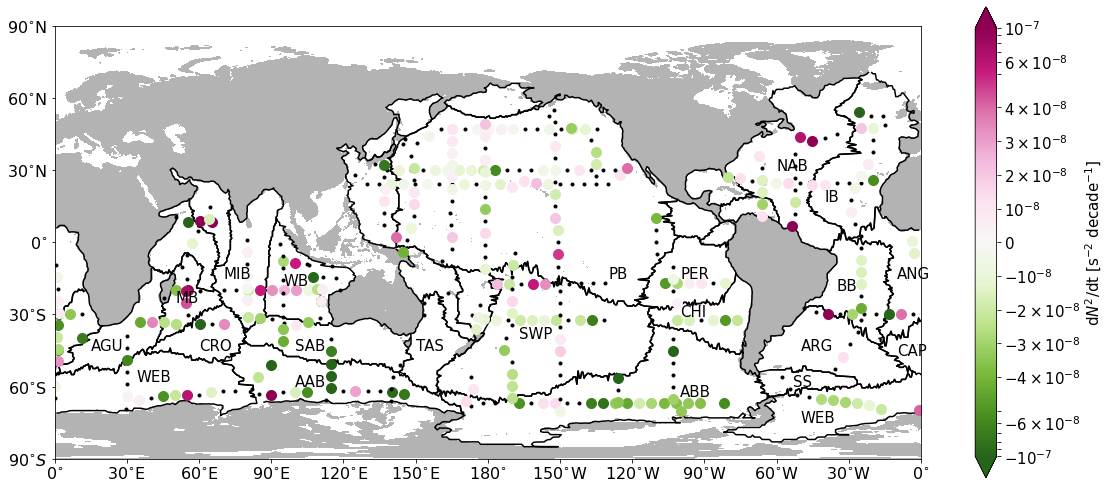

In [27]:
confidence_level=.68
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.eps')


In [28]:
param_fig = {'z_at': 0,
             'method_at': -1,
             'pic_name': 'depthlayer_up', 
             'cbar_on': 1,
}

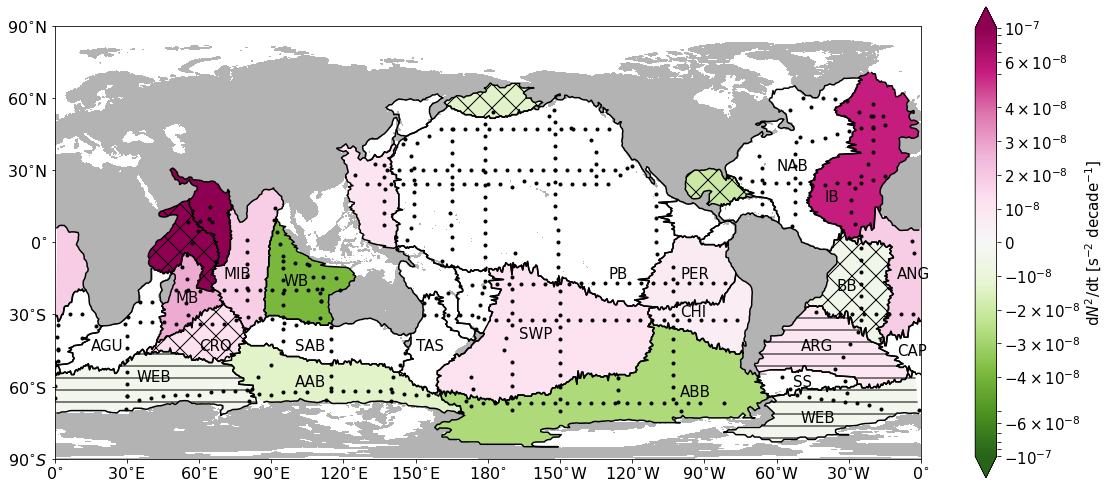

In [29]:
from matplotlib import cm

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['.7', 'y', 'dodgerblue', 'r'])
cmap.set_under('.7', 1.)
cmap.set_over('r', 1.)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_over_basin(N2_trend_all, Topo, basin, ax, param_fig)

_, var_keys = within_basin(var_lon, var_lat, 0)
for ii in range(len(var_keys)):
    idx_basin, var_keys = within_basin(var_lon, var_lat, ii)
    k = param_fig['z_at']
    lat_ = var_lat[idx_basin].copy()
    lon_ = var_lon[idx_basin].copy()
    for i in range(len(lat_)):
        if len(var[idx_basin, :][i, z_N2>=z_thred[k]][~np.isnan(var[idx_basin, :][i, z_N2>=z_thred[k]])]) == 0:
            lat_[i] = np.nan
            lon_[i] = np.nan
    ax.plot(lon_, lat_, '.', color='k')
    

ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_basin_N2trend_'+param_fig['pic_name']+'.eps')


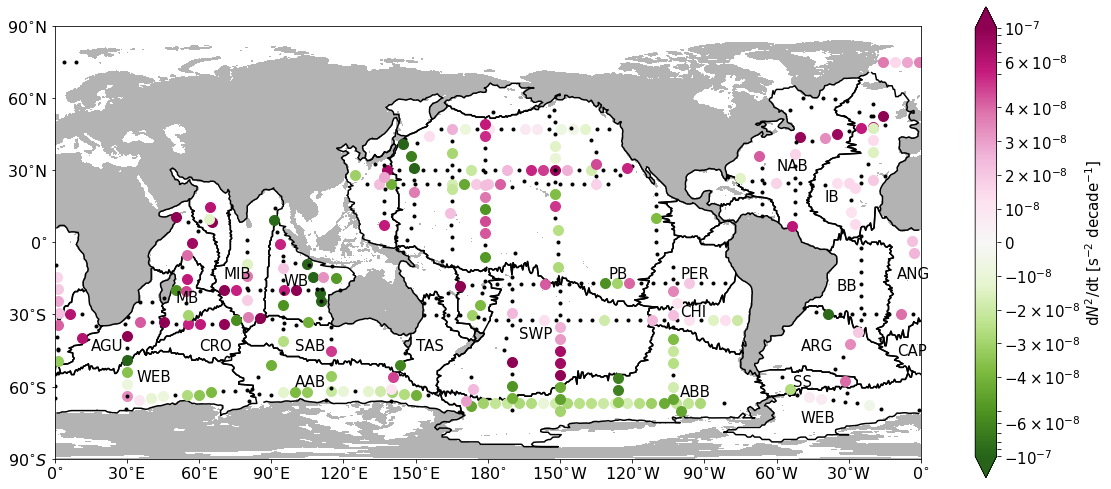

In [30]:
confidence_level=.95
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'.eps')


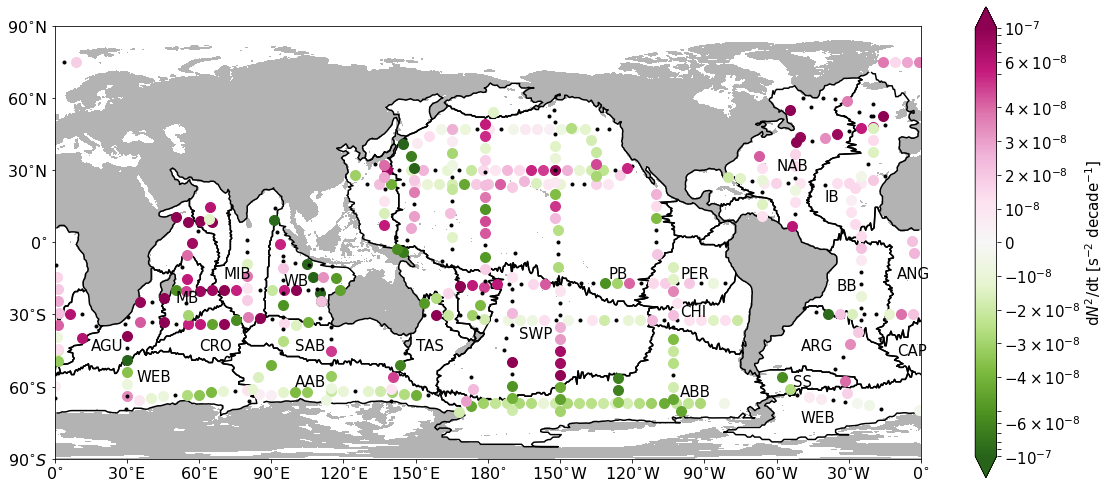

In [31]:
confidence_level=.68
if param_fig['z_at'] == 1:
    idx_range = (z_N2>=z_thred[1])
elif param_fig['z_at'] == 0: 
    idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
var_trend, _, var_trend_CI= err_from_mean(var[:, idx_range].T,
               var_err[:, idx_range].T,
               var_eDOF[:, idx_range].T, confidence_level=confidence_level)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
plot_trend_stations(var_lon, var_lat, var_trend, var_trend_CI, Topo, basin, param_fig, ax)


ax.text(30+4, -65+7, 'WEB', fontsize=15, c='k')
ax.text(20-5, -45, 'AGU', fontsize=15, c='k')
ax.text(60, -45, 'CRO', fontsize=15, c='k')
ax.text(50, -25, 'MB', fontsize=15, c='k')
ax.text(70, -15, 'MIB', fontsize=15, c='k')
ax.text(90+5, -20+2, 'WB', fontsize=15, c='k')
ax.text(100, -45, 'SAB', fontsize=15, c='k')
ax.text(110-10, -60, 'AAB', fontsize=15, c='k')
ax.text(150, -45, 'TAS', fontsize=15, c='k')
# ax.text(150, -20+5, 'CS', fontsize=15, c='k')
# ax.text(169, -22, 'ECS', fontsize=13, c='k')
ax.text(200-7, -40, 'SWP', fontsize=15, c='k')
ax.text(220+40, -70+6, 'ABB', fontsize=15, c='k')
ax.text(260, -35+4, 'CHI', fontsize=15, c='k')
ax.text(260, -15, 'PER', fontsize=15, c='k')
ax.text(230, -15, 'PB', fontsize=15, c='k')
ax.text(310, -45, 'ARG', fontsize=15, c='k')
ax.text(330-5, -20, 'BB', fontsize=15, c='k')
ax.text(310, -75, 'WEB', fontsize=15, c='k')
ax.text(350, -47, 'CAP', fontsize=15, c='k')
ax.text(350, -15, 'ANG', fontsize=15, c='k')
ax.text(310-10, 30, 'NAB', fontsize=15, c='k')
ax.text(330-10, 25-8, 'IB', fontsize=15, c='k')
ax.text(310-3, -60, 'SS', fontsize=15, c='k')

plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.jpeg', dpi=300)
plt.savefig(outfilepath+ 'EasyOcean_trks_station_N2trend_'+param_fig['pic_name']+'_CI68.eps')
